# 学習と評価
 - FaceNetの利用

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.8.0'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
from sklearn.model_selection import KFold

In [14]:
SEED = 1001

## データのロード

- 画像サイズは224×224

In [7]:
df = pd.read_csv("data1_union.csv")

In [8]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,272998,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,1.0,1.0,1.0,1.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,1.0,1.0,0.0,1.0,1.0,0.0,0.0
83,124821,0.0,1.0,1.0,1.0,0.0,0.0,1.0


## FaceNetで埋め込み

メモ：```\Lib\site-packages\facenet\src\facenet.py```の408行目をtensorflow v2仕様に書き換える必要がある

In [9]:
from face_embedding import FaceEmbedding

In [10]:
FACE_MEDEL_PATH = '../facenet//20180402-114759/20180402-114759.pb'
face_embedding = FaceEmbedding(FACE_MEDEL_PATH)

Model filename: ../facenet//20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [11]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    face_vec = face_embedding.face_embeddings(path)[0]
    X.append(face_vec)

In [12]:
X = np.array(X)

In [13]:
X.shape

(85, 512)

# 二値分類モデル

## モデル構築

In [18]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [19]:
def get_binary_model():
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4, seed=SEED)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4, seed=SEED)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2, seed=SEED)(dense6)
    final = Dense(2, activation="softmax")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [20]:
model = get_binary_model()

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [23]:
del model

In [25]:
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

In [26]:
from sklearn.metrics import f1_score

cf. https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook

In [27]:
from tensorflow.keras import backend as K

## すべてのラベルでやってみる

In [28]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [31]:
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

In [32]:
import gc

In [33]:
f1_dict = dict()
y_true_preds = dict()

for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    y_true_preds[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):     
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        print(f"origin pos:{pos} neg:{neg}")

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias
        
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)
        model.fit(X_train, y_train, batch_size=8, epochs=6, class_weight=class_weight)
        y_pred_tf = model.predict(X_test, batch_size=1)
        y_pred = np.argmax(y_pred_tf, axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
        y_true_preds[label].append((y_test_sk, y_pred))
        del model
        gc.collect()
    

Caring
origin pos:21.0 neg:35.0
Epoch 1/6
7/7 [==============================] - 1s 20ms/step - loss: 0.7010 - tp: 21.0000 - fp: 35.0000 - tn: 21.0000 - fn: 35.0000 - accuracy: 0.3750 - precision: 0.3750 - recall: 0.3750 - auc: 0.3273
Epoch 2/6
7/7 [==============================] - 0s 22ms/step - loss: 0.7112 - tp: 26.0000 - fp: 30.0000 - tn: 26.0000 - fn: 30.0000 - accuracy: 0.4643 - precision: 0.4643 - recall: 0.4643 - auc: 0.3941             
Epoch 3/6
7/7 [==============================] - 0s 7ms/step - loss: 0.6896 - tp: 32.0000 - fp: 24.0000 - tn: 32.0000 - fn: 24.0000 - accuracy: 0.5714 - precision: 0.5714 - recall: 0.5714 - auc: 0.5702
Epoch 4/6
7/7 [==============================] - 0s 6ms/step - loss: 0.6708 - tp: 36.0000 - fp: 20.0000 - tn: 36.0000 - fn: 20.0000 - accuracy: 0.6429 - precision: 0.6429 - recall: 0.6429 - auc: 0.7003
Epoch 5/6
7/7 [==============================] - 0s 6ms/step - loss: 0.5481 - tp: 48.0000 - fp: 8.0000 - tn: 48.0000 - fn: 8.0000 - accuracy: 0.8

8/8 [==============================] - 0s 8ms/step - loss: 0.1043 - tp: 55.0000 - fp: 2.0000 - tn: 55.0000 - fn: 2.0000 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9988 
Predict: [1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0]
True: [1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1]
F1 score: 0.7142857142857143
Emotionally stable
origin pos:16.0 neg:40.0
Epoch 1/6
7/7 [==============================] - 1s 10ms/step - loss: 0.6994 - tp: 71.0000 - fp: 42.0000 - tn: 71.0000 - fn: 42.0000 - accuracy: 0.6283 - precision: 0.6283 - recall: 0.6283 - auc: 0.7956
Epoch 2/6
7/7 [==============================] - 0s 10ms/step - loss: 0.6905 - tp: 15.0000 - fp: 41.0000 - tn: 15.0000 - fn: 41.0000 - accuracy: 0.2679 - precision: 0.2679 - recall: 0.2679 - auc: 0.3072
Epoch 3/6
7/7 [==============================] - 0s 10ms/step - loss: 0.6257 - tp: 35.0000 - fp: 21.0000 - tn: 35.0000 - fn: 21.0000 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6

8/8 [==============================] - 0s 11ms/step - loss: 0.6607 - tp: 30.0000 - fp: 27.0000 - tn: 30.0000 - fn: 27.0000 - accuracy: 0.5263 - precision: 0.5263 - recall: 0.5263 - auc: 0.6368
Epoch 5/6
8/8 [==============================] - 0s 12ms/step - loss: 0.5591 - tp: 44.0000 - fp: 13.0000 - tn: 44.0000 - fn: 13.0000 - accuracy: 0.7719 - precision: 0.7719 - recall: 0.7719 - auc: 0.8247
Epoch 6/6
8/8 [==============================] - 0s 12ms/step - loss: 0.3166 - tp: 49.0000 - fp: 8.0000 - tn: 49.0000 - fn: 8.0000 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9418
Predict: [0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1]
True: [0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1]
F1 score: 0.631578947368421
Responsible
origin pos:25.0 neg:31.0
Epoch 1/6
7/7 [==============================] - 1s 10ms/step - loss: 0.6892 - tp: 78.0000 - fp: 35.0000 - tn: 78.0000 - fn: 35.0000 - accuracy: 0.6903 - precision: 0.6903 - recall: 0.6903 - auc: 0.8251
Epoc

8/8 [==============================] - 0s 11ms/step - loss: 0.6752 - tp: 37.0000 - fp: 20.0000 - tn: 37.0000 - fn: 20.0000 - accuracy: 0.6491 - precision: 0.6491 - recall: 0.6491 - auc: 0.7553
Epoch 4/6
8/8 [==============================] - 0s 12ms/step - loss: 0.5726 - tp: 50.0000 - fp: 7.0000 - tn: 50.0000 - fn: 7.0000 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9394
Epoch 5/6
8/8 [==============================] - 0s 12ms/step - loss: 0.3624 - tp: 49.0000 - fp: 8.0000 - tn: 49.0000 - fn: 8.0000 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9372
Epoch 6/6
8/8 [==============================] - 0s 11ms/step - loss: 0.0929 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9791
Predict: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
True: [0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0]
F1 score: 0.30769230769230765
Trustworthy
origin pos:10.0 neg:46.0
Epoch 

In [36]:
HL = 0
cnt = 0
for l in labels:
    for k in range(3):
        y_true, y_pred = y_true_preds[label][k]
        HL += hamming_loss(y_true, y_pred)
        cnt += 1
HL /= cnt
HL

0.269704433497537

In [37]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))
macro_f1_val = np.mean(f1_list) 

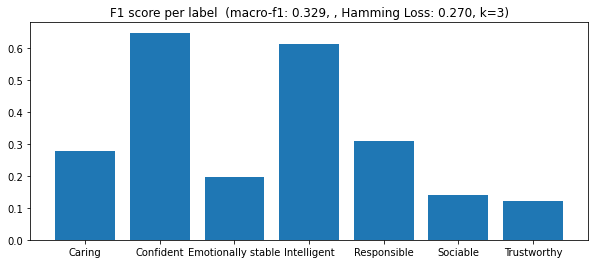

In [40]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title(f"F1 score per label  (macro-f1: {macro_f1_val:.3f}, , Hamming Loss: {HL:.3f}, k=3)")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない
 - 役に立たない　やはりデータが少なすぎるか
 - f1をlossに用いるほうが全然良い
 - macro-f1はf1の平均

# マルチラベル問題

In [41]:
def get_multi_model():
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4, seed=SEED)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4, seed=SEED)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2, seed=SEED)(dense6)
    final = Dense(len(labels), activation="sigmoid")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [42]:
model = get_multi_model()

In [43]:
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 512)]             0         
                                                                 
 dense_154 (Dense)           (None, 512)               262656    
                                                                 
 dense_155 (Dense)           (None, 1024)              525312    
                                                                 
 dropout_66 (Dropout)        (None, 1024)              0         
                                                                 
 dense_156 (Dense)           (None, 1024)              1049600   
                                                                 
 dropout_67 (Dropout)        (None, 1024)              0         
                                                                 
 dense_157 (Dense)           (None, 512)               524

In [44]:
df["Confident"].sum()

65.0

In [45]:
y = np.array(df.T[1:].T)

In [46]:
y[:10]

array([[1., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 1., 0.],
       [1., 1., 1., 0., 1., 1., 1.]])

In [47]:
y.sum(axis=0) # 各ラベルの数

array([26., 65., 29., 50., 41., 30., 19.])

In [48]:
len(X)

85

In [49]:
rate = y.sum(axis=0) / len(X) 

In [50]:
rate

array([0.30588235, 0.76470588, 0.34117647, 0.58823529, 0.48235294,
       0.35294118, 0.22352941])

In [51]:
y_preds = []
for train_index, test_index in kf.split(X):     
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = get_multi_model()

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    model.fit(X_train, y_train, batch_size=8, epochs=10)
    model.evaluate(X_test,y_test)
    y_pred = model.predict(X_test, batch_size=1)
    y_preds.append(y_pred)
    del model
    gc.collect()

Epoch 1/10
7/7 [==============================] - 0s 17ms/step - loss: 0.6732 - acc: 0.3750
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 0.6413 - acc: 0.4821
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6085 - acc: 0.4821
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.5695 - acc: 0.5000
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5707 - acc: 0.5000
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5486 - acc: 0.5179
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5330 - acc: 0.5000
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4917 - acc: 0.4643
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.4646 - acc: 0.4821
Epoch 10/10
1/1 [==============================] - 0s 108ms/step - loss: 0.7773 - acc: 0.4828
Epoch 1/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6833 - acc: 0

In [52]:
y_preds

[array([[0.3480044 , 0.96158415, 0.13790752, 0.82578725, 0.12868656,
         0.10724779, 0.05311371],
        [0.26353317, 0.8845837 , 0.24696907, 0.35228607, 0.7501337 ,
         0.27973256, 0.06813965],
        [0.43888357, 0.9287361 , 0.19063966, 0.8350435 , 0.11116539,
         0.14523025, 0.09537812],
        [0.3788582 , 0.6094732 , 0.41492474, 0.5163023 , 0.6441501 ,
         0.40490672, 0.29636797],
        [0.19188379, 0.6125812 , 0.21754777, 0.89803356, 0.5330028 ,
         0.14631735, 0.1408485 ],
        [0.29091945, 0.930504  , 0.15770687, 0.7670047 , 0.30581674,
         0.14160877, 0.06492046],
        [0.5590902 , 0.9684388 , 0.2034316 , 0.73024976, 0.0469426 ,
         0.16657452, 0.07682388],
        [0.3600059 , 0.5642307 , 0.42813316, 0.5240273 , 0.6689957 ,
         0.40250945, 0.31430492],
        [0.40854394, 0.48860016, 0.45666742, 0.58691907, 0.5781081 ,
         0.43073335, 0.40348426],
        [0.42971185, 0.9427252 , 0.17765503, 0.8340942 , 0.09983784,
    

In [53]:
y_preds_sk = []

In [54]:
for yp in y_preds:
    y_preds_sk.append(np.where(yp > 0.5,1,0))

In [55]:
y_preds_sk[0].T

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1],
       [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [35]:
from sklearn.metrics import hamming_loss

In [56]:
k = 0
hl = []
for train_index, test_index in kf.split(X):     
    y_train, y_test = y[train_index], y[test_index]
    l = hamming_loss(y_test, y_preds_sk[k])
    hl.append(l)
    k+=1
HL = np.mean(hl)
HL

0.384001876612714

In [57]:
f1_dict = dict()
for i,label in enumerate(labels):
    f1_dict[label] = []
    k = 0
    for train_index, test_index in kf.split(X):     
        y_train, y_test = y[train_index], y[test_index]
        y_pred_label = y_preds_sk[k].T[i]
        f1 = f1_score(y_test.T[i], y_pred_label, average="binary")
        f1_dict[label].append(f1)
        k+=1

In [58]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))
macro_f1_val = np.mean(f1_list) 

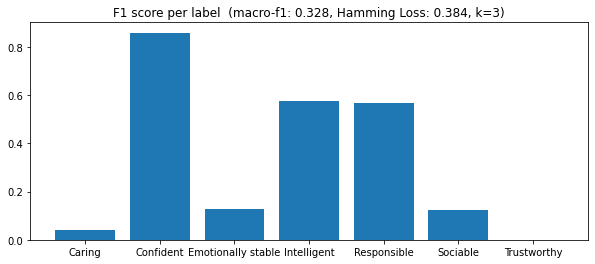

In [61]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title(f"F1 score per label  (macro-f1: {macro_f1_val:.3f}, Hamming Loss: {HL:.3f}, k=3)")
plt.show() ;

In [190]:
import japanize_matplotlib

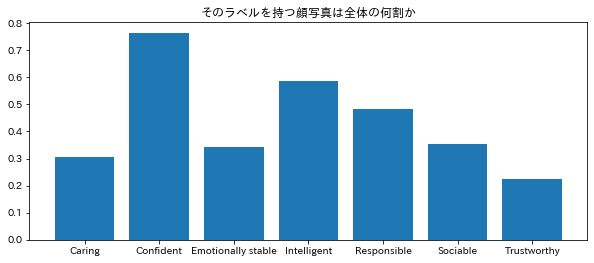

In [191]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), rate)
plt.title(f"そのラベルを持つ顔写真は全体の何割か")
plt.show() ;